In [2]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

In [8]:
def simulacao_percolacao(N, p):
    percolou = False
    maior_cluster = 0
    num_clusters = 0

    grade = np.random.rand(N, N) < p
    grade = np.where(grade, 1, 0)

    if not np.any(grade):
        return False, 0, 0
    # Se a matriz for inteiramente de zeros, já retorna que não percola e não teve clusters

    estrutura = ndimage.generate_binary_structure(rank=2, connectivity=1)
    # Define a estrutura de Vizinhos de von Neumann

    grade_clusters, num_clusters = ndimage.label(grade, estrutura)
    # Função de etiquetar as matrizes em clusters

    coluna_1 = grade_clusters[:, 0]
    coluna_n = grade_clusters[:, -1]
    linha_1 = grade_clusters[0]
    linha_n = grade_clusters[-1]

    intersecoes_vertical = np.intersect1d(linha_1, linha_n)
    intersecoes_horizontal = np.intersect1d(coluna_1, coluna_n)
    percolou_vertical = np.any(intersecoes_vertical > 0)
    percolou_horizontal = np.any(intersecoes_horizontal > 0)
    if percolou_vertical or percolou_horizontal:
        percolou = True

    grade_clusters_d1 = np.ravel(grade_clusters)
    contagem = np.bincount(grade_clusters_d1)
    # Conta ocupação de cada etiqueta de cluster
    maior_cluster = max(contagem[1:])
    # Maior cluster é o elemento que ocupou mais sítios (excluindo o zero)

    return percolou, maior_cluster, num_clusters

perc, maior, num = simulacao_percolacao(6, 0.5)
print(f"O sistema percolou? {perc}")
print(f"Qual o tamanho do maior cluster? {maior}")
print(f"Qual o número total de clusters? {num}")


O sistema percolou? False
Qual o tamanho do maior cluster? 4
Qual o número total de clusters? 6


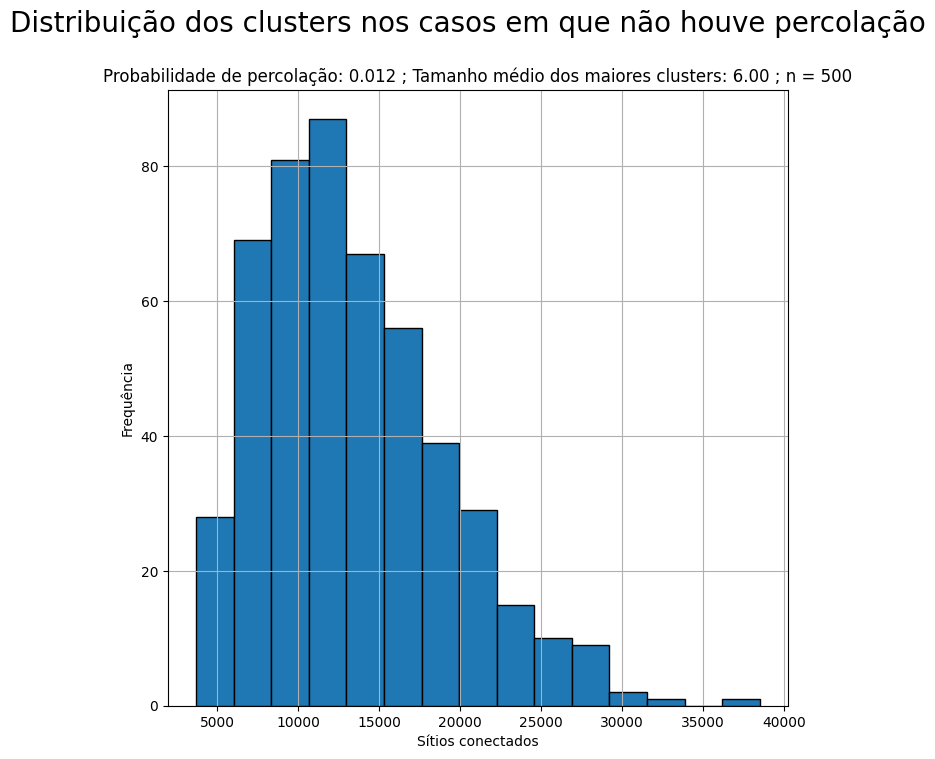

(0.012, '14553.56')

In [10]:
# Função que calcula tanto a probabilidade de percolação dado N, p e n quanto a média do maior cluster

def prob_percolacao_e_media_cluster(N, p, n):
  valores_cluster = []
  per, soma, nao_percola = 0, 0, 0
  for i in range(n):
    y = simulacao_percolacao(N, p)
    if y[0] == True:
      per += 1
    else:
      nao_percola += 1
      soma += y[1]
      valores_cluster.append(y[1])
  if nao_percola == 0:
    media = 0
  else:
    media = soma/nao_percola
  prob_per = per/n

  return valores_cluster, per, media, prob_per

def grafico(N, p, n):
  y = prob_percolacao_e_media_cluster(N, p, n)
  plt.figure(figsize=(8,8))
  plt.hist(y[0], align='left', edgecolor='black', bins=15)
  plt.suptitle('Distribuição dos clusters nos casos em que não houve percolação', size=20)
  plt.title(f'Probabilidade de percolação: {y[3]} ; Tamanho médio dos maiores clusters: {y[1]:.2f} ; n = {n}')
  plt.xlabel('Sítios conectados')
  plt.ylabel('Frequência')
  plt.grid(True)
  plt.show()
  return y[3], f'{y[2]:.2f}'

grafico(512, 0.58, 500)

In [23]:
def limiar_critico(n, plotar=False):
    lista_p = np.linspace(0.0, 1.0, 51)
    lista_N = [16, 64, 128, 256, 512, 1024]
    lista_limiares = []

    for N in lista_N:
        lista_probs_N = []
        for p in lista_p:
            prob_per = prob_percolacao_e_media_cluster(N, p, n)[3]
            lista_probs_N.append(prob_per)
        print(lista_probs_N)

        p_limiar = np.interp(0.5, lista_probs_N, lista_p)
        lista_limiares.append(p_limiar)

        if plotar:
            plt.figure(figsize=(15,8))
            plt.xlabel('Probabilidade p')
            plt.ylabel('Probabilidade de Percolação θ(p)')
            plt.title(f'Curva de Percolação para N={N}')
            plt.axhline(0.5, color='red', linestyle='--', label='θ(p) = 0.5')
            plt.axvline(p_limiar, color='black', linestyle=':', label=f'p limiar para N={N} = {p_limiar:.3f}')
            plt.plot(lista_p, lista_probs_N, marker='o')
            plt.grid(True)
            plt.legend()
            plt.show()

    lista_1N = np.array(1 / np.array(lista_N))
    plt.figure(figsize=(8,8))
    plt.xlabel('N')
    plt.ylabel('Limiar pc(N)')
    plt.title(f'Limiares finitos versus N')
    plt.plot(lista_N, lista_limiares, marker='o')
    for x, y in zip(lista_N, lista_limiares):
        plt.text(x, y, f"({x}, {y:.5f})", ha='left', va='bottom')
    plt.grid(True)
    plt.show()
    
        
limiar_critico(500, False)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.004, 0.0, 0.002, 0.012, 0.016, 0.052, 0.064, 0.128, 0.24, 0.326, 0.464, 0.616, 0.704, 0.856, 0.932, 0.962, 0.988, 0.996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004, 0.008, 0.018, 0.158, 0.458, 0.802, 0.952, 0.996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


KeyboardInterrupt: 